# Solar Energy Production Zone Clustering

In [1]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer

# Data Collection

In [2]:
slr_ep = pd.read_csv("Statewide Solar Projects.csv")
slr_ep

,Data Through Date,Project ID,Interconnection Date,Utility,City/Town,County,Zip,Division,Substation,Circuit ID,Developer,Metering Method,Estimated PV System Size (kWdc),PV System Size (kWac),Estimated Annual PV Energy Production (kWh),Energy Storage System Size (kWac),Number of Projects
0,12/31/2023,SDG-66301,12/29/2023,Con Ed,Richmond Hill,Queens,11418.0,CENY-BK,Brownsville_2,9B05,Kamtech Solar Solutions,NM,6.05,5.17,7100,NaN,1
1,12/31/2023,SDG-66299,12/29/2023,Con Ed,Bronx,Bronx,10473.0,CENY-BX,Parkchester_2,5X67,Kamtech Solar Solutions,NM,6.74,5.76,7911,NaN,1
2,12/31/2023,SDG-66288,12/29/2023,Con Ed,Brooklyn,Kings,11225.0,CENY-BK,Bensonhurst_2,4B08,SUNCO,NM,3.05,2.61,3585,NaN,1
3,12/31/2023,SDG-66284,12/29/2023,Con Ed,Brooklyn,Kings,11236.0,CENY-BK,Bensonhurst_2,3037,Kamtech Solar Solutions,NM,5.62,4.80,6592,NaN,1
4,12/31/2023,SDG-66277,12/28/2023,Con Ed,Springfield Gardens,Queens,11413.0,CENY-Q,Jamaica,9112,Kamtech Solar Solutions,NM,6.05,5.17,7100,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218110,12/31/2023,49.0,12/19/2002,RGE,Ontario,Wayne,14519.0,Sodus,0205LS0237-1589 RTE 104,0205LS0237,NaN,NM,2.81,2.40,3296,NaN,1
218111,12/31/2023,48.0,9/24/2002,RGE,Friendship,Allegany,14739.0,Fillmore,8333GV7702-Friendship Nile RD,8333GV7702,NaN,NM,2.93,2.50,3433,NaN,1
218112,12/31/2023,NaN,7/1/2018,PSEGLI,NaN,Suffolk,11786.0,NaN,NaN,NaN,NaN,FIT,34362.00,24900.00,40335490,NaN,1
218113,12/31/2023,NaN,3/3/2018,PSEGLI,NaN,Suffolk,11933.0,NaN,NaN,NaN,NaN,FIT,27600.00,20000.00,32397984,NaN,1


# Data Exploration

In [3]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(slr_ep.head())

First few rows of the dataset:
  Data Through Date Project ID Interconnection Date Utility  \
0        12/31/2023  SDG-66301           12/29/2023  Con Ed   
1        12/31/2023  SDG-66299           12/29/2023  Con Ed   
2        12/31/2023  SDG-66288           12/29/2023  Con Ed   
3        12/31/2023  SDG-66284           12/29/2023  Con Ed   
4        12/31/2023  SDG-66277           12/28/2023  Con Ed   

             City/Town  County      Zip Division     Substation Circuit ID  \
0        Richmond Hill  Queens  11418.0  CENY-BK  Brownsville_2       9B05   
1                Bronx   Bronx  10473.0  CENY-BX  Parkchester_2       5X67   
2             Brooklyn   Kings  11225.0  CENY-BK  Bensonhurst_2       4B08   
3             Brooklyn   Kings  11236.0  CENY-BK  Bensonhurst_2       3037   
4  Springfield Gardens  Queens  11413.0   CENY-Q        Jamaica       9112   

                 Developer Metering Method  Estimated PV System Size (kWdc)  \
0  Kamtech Solar Solutions              NM

In [4]:
# Summary statistics of numerical features
print("\nSummary statistics of numerical features:")
print(slr_ep.describe())


Summary statistics of numerical features:
                 Zip  Estimated PV System Size (kWdc)  PV System Size (kWac)  \
count  218019.000000                    218115.000000          218115.000000   
mean    11751.734473                        24.507977              19.065451   
std       962.129108                       291.525394             211.419642   
min     10001.000000                         0.010000               0.010000   
25%     11220.000000                         5.270000               4.500000   
50%     11717.000000                         7.130000               6.090000   
75%     12018.000000                        10.240000               8.750000   
max     14905.000000                     43470.000000           31500.000000   

       Estimated Annual PV Energy Production (kWh)  \
count                                 2.181150e+05   
mean                                  2.876828e+04   
std                                   3.422042e+05   
min                 

In [5]:
# Check data types and missing values
print("\nData types and missing values:")
print(slr_ep.info())


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218115 entries, 0 to 218114
Data columns (total 17 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Data Through Date                            218115 non-null  object 
 1   Project ID                                   218112 non-null  object 
 2   Interconnection Date                         218115 non-null  object 
 3   Utility                                      218115 non-null  object 
 4   City/Town                                    218057 non-null  object 
 5   County                                       218115 non-null  object 
 6   Zip                                          218019 non-null  float64
 7   Division                                     132881 non-null  object 
 8   Substation                                   138171 non-null  object 
 9   Circuit ID                 

In [6]:
# Check for missing values
print("\nNumber of missing values per column:")
print(slr_ep.isnull().sum())


Number of missing values per column:
Data Through Date                                   0
Project ID                                          3
Interconnection Date                                0
Utility                                             0
City/Town                                          58
County                                              0
Zip                                                96
Division                                        85234
Substation                                      79944
Circuit ID                                         30
Developer                                       10550
Metering Method                                   463
Estimated PV System Size (kWdc)                     0
PV System Size (kWac)                               0
Estimated Annual PV Energy Production (kWh)         0
Energy Storage System Size (kWac)              214024
Number of Projects                                  0
dtype: int64


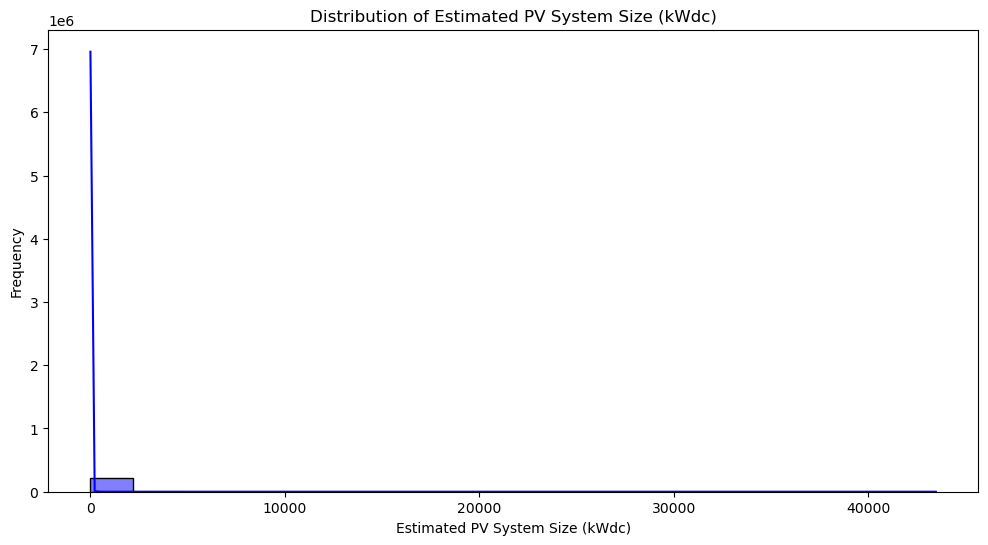

In [7]:
# Visualize distributions of numerical features
plt.figure(figsize=(12, 6))
sns.histplot(slr_ep['Estimated PV System Size (kWdc)'], bins=20, kde=True, color='blue')
plt.title('Distribution of Estimated PV System Size (kWdc)')
plt.xlabel('Estimated PV System Size (kWdc)')
plt.ylabel('Frequency')
plt.show()

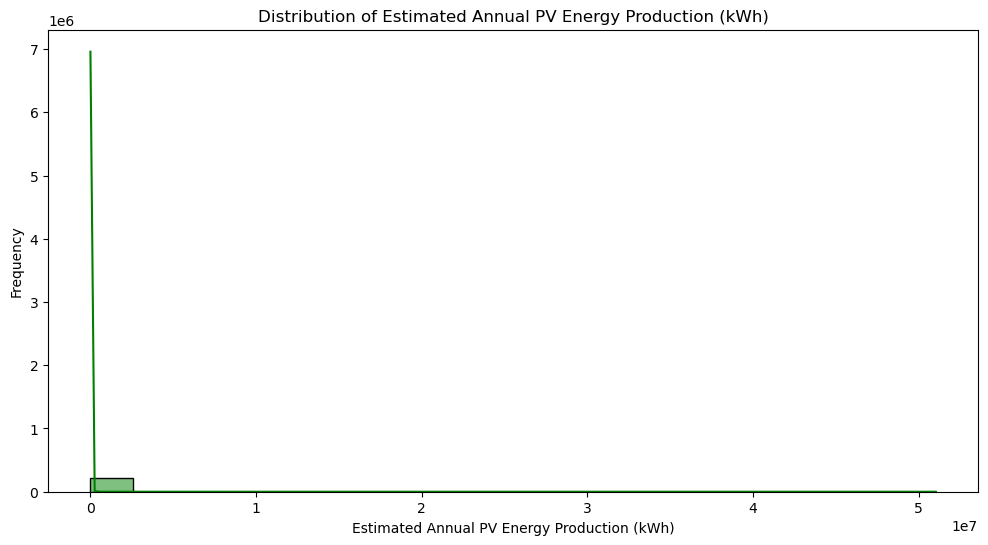

In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(slr_ep['Estimated Annual PV Energy Production (kWh)'], bins=20, kde=True, color='green')
plt.title('Distribution of Estimated Annual PV Energy Production (kWh)')
plt.xlabel('Estimated Annual PV Energy Production (kWh)')
plt.ylabel('Frequency')
plt.show()

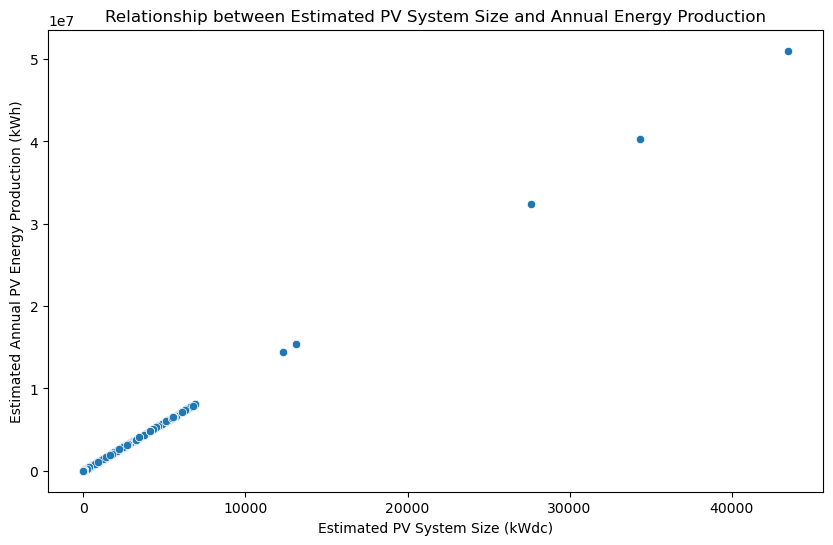

In [9]:
# Visualize relationships between numerical features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=slr_ep, x='Estimated PV System Size (kWdc)', y='Estimated Annual PV Energy Production (kWh)')
plt.title('Relationship between Estimated PV System Size and Annual Energy Production')
plt.xlabel('Estimated PV System Size (kWdc)')
plt.ylabel('Estimated Annual PV Energy Production (kWh)')
plt.show()

# Data Preprocessing

In [10]:
# Handle missing values
# Let's impute missing values in numerical columns with the mean
num_imputer = SimpleImputer(strategy='mean')
numerical_columns = slr_ep.select_dtypes(include=['float64', 'int64']).columns
slr_ep[numerical_columns] = num_imputer.fit_transform(slr_ep[numerical_columns])

In [11]:
# For categorical columns, let's impute missing values with the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')
categorical_columns = slr_ep.select_dtypes(include=['object']).columns
slr_ep[categorical_columns] = cat_imputer.fit_transform(slr_ep[categorical_columns])

In [12]:
# Check for missing values
print("\nNumber of missing values per column:")
print(slr_ep.isnull().sum())


Number of missing values per column:
Data Through Date                              0
Project ID                                     0
Interconnection Date                           0
Utility                                        0
City/Town                                      0
County                                         0
Zip                                            0
Division                                       0
Substation                                     0
Circuit ID                                     0
Developer                                      0
Metering Method                                0
Estimated PV System Size (kWdc)                0
PV System Size (kWac)                          0
Estimated Annual PV Energy Production (kWh)    0
Energy Storage System Size (kWac)              0
Number of Projects                             0
dtype: int64


In [13]:
# Convert categorical variables into numerical representations using one-hot encoding
# Assuming 'Metering Method' is a categorical variable to be one-hot encoded
slr_ep_encoded = pd.get_dummies(slr_ep, columns=['Metering Method'])


# Display the preprocessed dataset
print("Preprocessed dataset:")
print(slr_ep_encoded.head())

Preprocessed dataset:
  Data Through Date Project ID Interconnection Date Utility  \
0        12/31/2023  SDG-66301           12/29/2023  Con Ed   
1        12/31/2023  SDG-66299           12/29/2023  Con Ed   
2        12/31/2023  SDG-66288           12/29/2023  Con Ed   
3        12/31/2023  SDG-66284           12/29/2023  Con Ed   
4        12/31/2023  SDG-66277           12/28/2023  Con Ed   

             City/Town  County      Zip Division     Substation Circuit ID  \
0        Richmond Hill  Queens  11418.0  CENY-BK  Brownsville_2       9B05   
1                Bronx   Bronx  10473.0  CENY-BX  Parkchester_2       5X67   
2             Brooklyn   Kings  11225.0  CENY-BK  Bensonhurst_2       4B08   
3             Brooklyn   Kings  11236.0  CENY-BK  Bensonhurst_2       3037   
4  Springfield Gardens  Queens  11413.0   CENY-Q        Jamaica       9112   

   ... PV System Size (kWac)  Estimated Annual PV Energy Production (kWh)  \
0  ...                  5.17                         

#  Feature Selection/Engineering

In [14]:
# Select relevant features for clustering
selected_features = ['City/Town', 'County', 'Zip', 'Estimated PV System Size (kWdc)',
                     'Estimated Annual PV Energy Production (kWh)']
slr_ep_selected = slr_ep[selected_features]

# Engineer new features
# Calculate the ratio of PV system size to energy production
slr_ep_selected['System Size to Energy Production Ratio'] = slr_ep_selected[
    'Estimated PV System Size (kWdc)'] / slr_ep_selected['Estimated Annual PV Energy Production (kWh)']

# Display the selected and engineered features
print("Selected and engineered features:")
print(slr_ep_selected.head())

Selected and engineered features:
             City/Town  County      Zip  Estimated PV System Size (kWdc)  \
0        Richmond Hill  Queens  11418.0                             6.05   
1                Bronx   Bronx  10473.0                             6.74   
2             Brooklyn   Kings  11225.0                             3.05   
3             Brooklyn   Kings  11236.0                             5.62   
4  Springfield Gardens  Queens  11413.0                             6.05   

   Estimated Annual PV Energy Production (kWh)  \
0                                       7100.0   
1                                       7911.0   
2                                       3585.0   
3                                       6592.0   
4                                       7100.0   

   System Size to Energy Production Ratio  
0                                0.000852  
1                                0.000852  
2                                0.000851  
3                               

# Normalization/Standardization

In [15]:
# Extract numerical columns
numerical_columns = ['Estimated PV System Size (kWdc)', 'PV System Size (kWac)',
                     'Estimated Annual PV Energy Production (kWh)', 'Energy Storage System Size (kWac)', 'Number of Projects']

# Initialize the scaler
# You can choose either StandardScaler or MinMaxScaler based on your preference
scaler = StandardScaler()  # Or MinMaxScaler()

# Fit and transform the numerical columns
slr_ep[numerical_columns] = scaler.fit_transform(slr_ep[numerical_columns])

# Display the normalized/standardized DataFrame
print("Normalized/Standardized DataFrame:")
print(slr_ep.head())

Normalized/Standardized DataFrame:
  Data Through Date Project ID Interconnection Date Utility  \
0        12/31/2023  SDG-66301           12/29/2023  Con Ed   
1        12/31/2023  SDG-66299           12/29/2023  Con Ed   
2        12/31/2023  SDG-66288           12/29/2023  Con Ed   
3        12/31/2023  SDG-66284           12/29/2023  Con Ed   
4        12/31/2023  SDG-66277           12/28/2023  Con Ed   

             City/Town  County      Zip Division     Substation Circuit ID  \
0        Richmond Hill  Queens  11418.0  CENY-BK  Brownsville_2       9B05   
1                Bronx   Bronx  10473.0  CENY-BX  Parkchester_2       5X67   
2             Brooklyn   Kings  11225.0  CENY-BK  Bensonhurst_2       4B08   
3             Brooklyn   Kings  11236.0  CENY-BK  Bensonhurst_2       3037   
4  Springfield Gardens  Queens  11413.0   CENY-Q        Jamaica       9112   

                 Developer Metering Method  Estimated PV System Size (kWdc)  \
0  Kamtech Solar Solutions            

# Clustering Algorithm Selection

# MiniBatchKMeans

In [16]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Select numerical columns for clustering
numerical_columns = ['Estimated PV System Size (kWdc)', 'PV System Size (kWac)', 
                     'Estimated Annual PV Energy Production (kWh)', 'Energy Storage System Size (kWac)']

# Extract numerical features for clustering
X = slr_ep[numerical_columns]

# Define the number of clusters
n_clusters = 9

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize MiniBatchKMeans clustering algorithm
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)

# Fit the algorithm to the data
kmeans.fit(X_scaled)

# Evaluate the clustering algorithm
silhouette_score_kmeans = silhouette_score(X_scaled, kmeans.labels_)

# Print silhouette score
print("Silhouette Score (MiniBatchKMeans):", silhouette_score_kmeans)

Silhouette Score (MiniBatchKMeans): 0.7526529886371267


# Gaussian Mixture Model

In [17]:
# Select numerical columns for clustering
numerical_columns = ['Estimated PV System Size (kWdc)', 'PV System Size (kWac)',
                     'Estimated Annual PV Energy Production (kWh)', 'Energy Storage System Size (kWac)', 'Number of Projects']

# Select and preprocess numerical data for clustering
X = slr_ep[numerical_columns].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the number of clusters
n_clusters = 9

# Initialize and fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
gmm_labels = gmm.predict(X_scaled)

# Evaluate the GMM clustering using silhouette score
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)

# Display silhouette score for GMM
print("Gaussian Mixture Model Silhouette Score:", gmm_silhouette)

Gaussian Mixture Model Silhouette Score: 0.924949060242125


# Clustering

In [18]:
# Extract features for clustering
X = slr_ep[['Estimated PV System Size (kWdc)', 'PV System Size (kWac)',
            'Estimated Annual PV Energy Production (kWh)', 'Energy Storage System Size (kWac)']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Gaussian Mixture Model
n_components = 9 # You can adjust the number of clusters as needed
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
cluster_labels = gmm.predict(X_scaled)

# Add cluster labels to the original dataframe
slr_ep['Cluster'] = cluster_labels

# Print the counts of samples in each cluster
print(slr_ep['Cluster'].value_counts())

Cluster
0    208738
6      4731
5      3806
4       547
1       159
8        97
2        32
3         4
7         1
Name: count, dtype: int64


# Conclusion:
The clustering analysis revealed valuable insights into the spatial distribution and characteristics of solar energy production zones. These findings can inform decision-making processes related to infrastructure planning, resource allocation, and policy development in the renewable energy sector. By identifying common patterns and outliers in solar energy production, stakeholders can develop targeted strategies to maximize the efficiency and sustainability of solar energy utilization.